In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("train.csv")

Price distribution

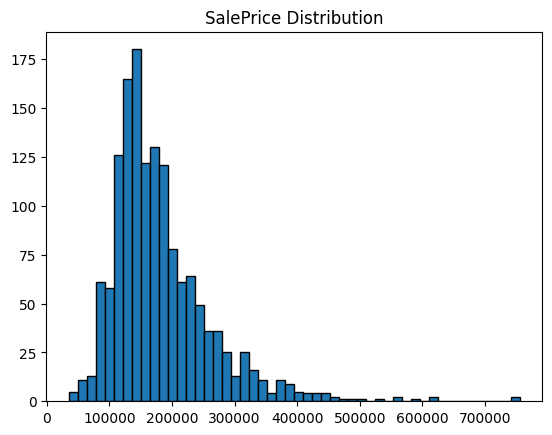

1.8828757597682129

In [4]:
plt.hist(df['SalePrice'], bins=50, edgecolor="black")
plt.title("SalePrice Distribution")
plt.show()
df['SalePrice'].skew()

We change to log scale to reduce right-skewness and stabilize variance

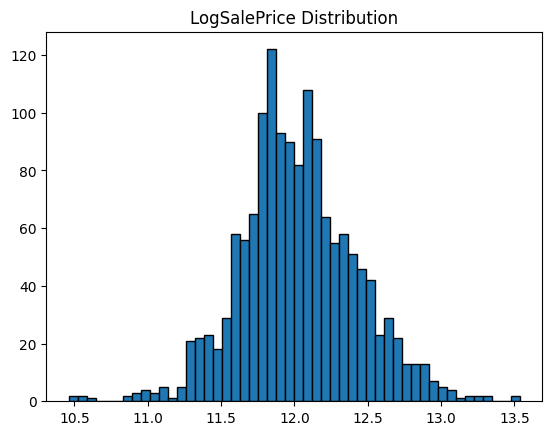

0.12134661989685329

In [5]:
df['LogSalePrice'] = np.log1p(df['SalePrice'])

plt.hist(df['LogSalePrice'], bins=50, edgecolor="black")
plt.title("LogSalePrice Distribution")
plt.show()
df['LogSalePrice'].skew()

In [6]:
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageCond        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

### Handling missing values

Basement doesn't exist

In [7]:
bsmt_cat = [
    'BsmtQual','BsmtCond','BsmtExposure',
    'BsmtFinType1','BsmtFinType2'
]

bsmt_num = [
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
    'TotalBsmtSF','BsmtFullBath','BsmtHalfBath'
]

df[bsmt_cat] = df[bsmt_cat].fillna('NoBasement')
df[bsmt_num] = df[bsmt_num].fillna(0)

Garage doesn't exist

In [8]:
garage_cat = ['GarageType','GarageFinish','GarageQual','GarageCond']
garage_num = ['GarageCars','GarageArea']

df[garage_cat] = df[garage_cat].fillna('NoGarage')
df[garage_num] = df[garage_num].fillna(0)
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

Masonry veneer doesn't exist

In [ ]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

Lot Frontage based on neighborhood median if possible

In [47]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

Features don't exist

In [ ]:
df['FireplaceQu'] = df['FireplaceQu'].fillna('NoFireplace')
df['PoolQC'] = df['PoolQC'].fillna('NoPool')
df['Fence'] = df['Fence'].fillna('NoFence')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Alley'] = df['Alley'].fillna('NoAlley')

Electrical filled by mode (SBrkr)

In [48]:
df.groupby('Electrical').count()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
Electrical,,,,,,,,,,,,,,,,,,,,,
FuseA,94,94,94,94,94,94,94,94,94,94,...,94,94,94,94,94,94,94,94,94,94
FuseF,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
FuseP,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
Mix,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
SBrkr,1334,1334,1334,1334,1334,1334,1334,1334,1334,1334,...,1334,1334,1334,1334,1334,1334,1334,1334,1334,1334


In [49]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [50]:
df.isnull().sum().sort_values(ascending=False).head(5)

Id             0
GarageCars     0
GarageYrBlt    0
GarageType     0
FireplaceQu    0
dtype: int64

### One Hot Encoding

In [51]:
y = df['LogSalePrice']
X = df.drop(columns=['SalePrice', 'LogSalePrice'])

In [52]:
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

print(f"Categorical: {len(cat_cols)}")
print(f"Numerical: {len(num_cols)}")

Categorical: 43
Numerical: 37


In [54]:
X_encoded = pd.get_dummies(
    X,
    columns=cat_cols,
    drop_first=True
)
X_encoded.shape

(1460, 260)

### Train/Test Splitting

In [78]:
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

### Linear Regression

In [100]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

preds = linear_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
rmse

0.1730740502401914

### Ridge Regression

In [101]:
ridge_model = Ridge(alpha=2)
ridge_model.fit(X_train, y_train)

preds = ridge_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))

rmse

0.13815645329105922

### XGBoost

In [91]:
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

preds = xgb_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))

rmse


0.13502986363532207

In [77]:
importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_encoded.columns
).sort_values(ascending=False)

importances.head(15)

ExterQual_TA               0.185947
OverallQual                0.131260
GarageCars                 0.090165
FireplaceQu_NoFireplace    0.042746
CentralAir_Y               0.041871
GarageCond_TA              0.041170
KitchenAbvGr               0.031445
GrLivArea                  0.031009
KitchenQual_TA             0.029343
MSZoning_RM                0.025644
Fireplaces                 0.016958
FullBath                   0.014461
Alley_NoAlley              0.013493
GarageType_Attchd          0.012696
GarageFinish_Unf           0.010218
dtype: float32